<a href="https://colab.research.google.com/github/michaelsyao/AI_in_Finance/blob/main/10_vectorized_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vectorized Backtesting

In [1]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

## Backtesting an SMA-Based Strategy

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
symbol = 'EUR='

In [4]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [6]:
data['SMA1'] = data[symbol].rolling(42).mean()

In [7]:
data['SMA2'] = data[symbol].rolling(258).mean()

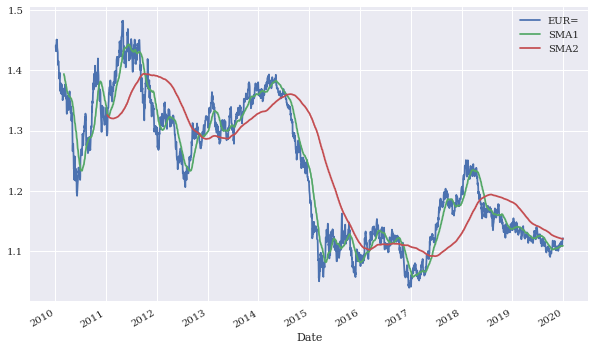

In [8]:
data.plot(figsize=(10, 6));

In [9]:
data.dropna(inplace=True)

In [10]:
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [11]:
data['p'] = data['p'].shift(1)

In [12]:
data.dropna(inplace=True)

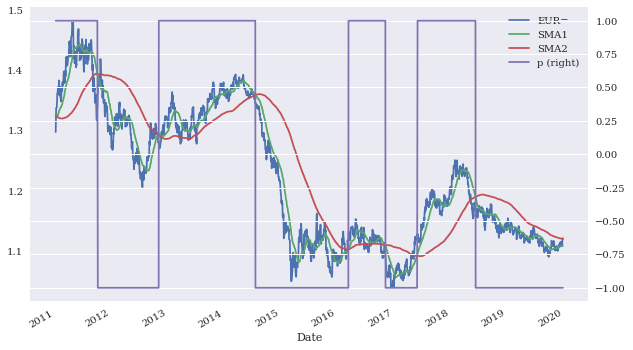

In [13]:
data.plot(figsize=(10, 6), secondary_y='p');

In [14]:
data['r'] = np.log(data[symbol] / data[symbol].shift(1))

In [15]:
data.dropna(inplace=True)

In [16]:
data['s'] = data['p'] * data['r']

In [17]:
data[['r', 's']].sum().apply(np.exp)  # gross performance

r   0.8640
s   1.3773
dtype: float64

In [21]:
data[['r', 's']].sum().apply(np.exp) - 1  # net performance

r   -0.1360
s    0.3773
dtype: float64

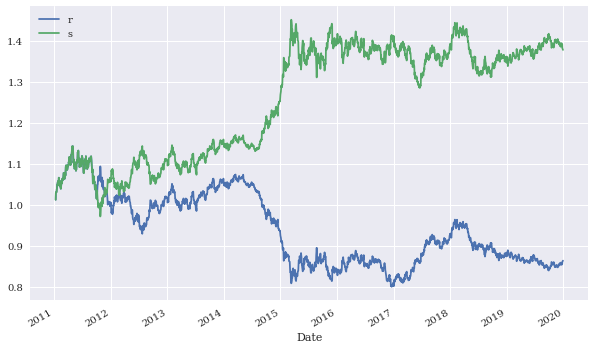

In [22]:
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [23]:
sum(data['p'].diff() != 0) + 1

9

In [24]:
pc = 0.005

In [25]:
data['s_'] = np.where(data['p'].diff() != 0,
                      data['s'] - pc, data['s'])

In [26]:
data['s_'].iloc[-1] -= pc

In [27]:
data[['r', 's', 's_']][data['p'].diff() != 0]

,r,s,s_
Date,,,
2011-01-12,0.0123,0.0123,0.0073
2011-10-10,0.0198,-0.0198,-0.0248
2012-11-07,-0.0034,-0.0034,-0.0084
2014-07-24,-0.0001,0.0001,-0.0049
2016-03-16,0.0102,0.0102,0.0052
2016-11-10,-0.0018,0.0018,-0.0032
2017-06-05,-0.0025,-0.0025,-0.0075
2018-06-15,0.0035,-0.0035,-0.0085
